In [1]:
import uproot
from scipy.constants import epsilon_0, e as q_e
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from stl import mesh
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

/tmp/ipykernel_3052041/397736156.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
def read_rootfile(file):
    #file = '00_iteration0_num5000.root' #'13_iteration5_from_num1000000.root'
    file_path = f"/storage/coda1/p-zjiang33/0/shared/avira7/root_files/sphere-charging/{file}"
    tree_name = "Hit Data"

    with uproot.open(file_path) as file:
        
        tree = file[tree_name]
        branch_names = tree.keys()
        branch_vars = {}
        for name in branch_names:
            branch_vars[name] = tree[name].array(library="np")

    df = pd.DataFrame(branch_vars)
    df['Kinetic_Energy_Diff_eV'] = (df['Kinetic_Energy_Pre_MeV'] - df['Kinetic_Energy_Post_MeV'])*1e6 # convert to eV

    df_lastevents = df.drop_duplicates(subset="Event_Number", keep="last")
    electrons_inside = df_lastevents[(df_lastevents["Volume_Name_Post"]=="G4_SILICON_DIOXIDE")&(df_lastevents["Particle_Type"]=="e-")]
    #electrons_outside = df_lastevents[(df_lastevents["Volume_Name_Post"]=="World")&(df_lastevents["Particle_Type"]=="e-")]

    return df, electrons_inside #, electrons_outside

In [19]:
%matplotlib widget

def plot_electron_positions(df,world_dimensions = (-0.05, 0.05), n_bins=100, iteration="iteration0", stacked_spheres=None):

    # Define voxel edges
    x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

    coords = np.vstack(df["Post_Step_Position_mm"])  # mm to m
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    # Compute 3D histogram: sum of energy lost in each voxel
    hist_electrons, edges = np.histogramdd(
        np.column_stack((x, y, z)),
        bins=(x_edges, y_edges, z_edges)
    )

    # Get voxel centers for plotting
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
    z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
    X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

    # Mask nonzero voxels and flatten arrays for plotting
    mask = hist_electrons > 0
    Xf_electrons = X[mask]
    Yf_electrons = Y[mask]
    Zf_electrons = Z[mask]
    hist_values_electrons = hist_electrons[mask]

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")


    if stacked_spheres is not None:

        # Create a collection of polygons (triangles)
        collection = Poly3DCollection(stacked_spheres.vectors, alpha=0.2, edgecolor="darkblue",linewidth=0.1)
        collection.set_facecolor('lightblue')
        ax.add_collection3d(collection)

        # Auto scale to the mesh size
        scale = stacked_spheres.points.flatten()
        ax.auto_scale_xyz(scale, scale, scale)
    else:

        # Set sphere parameters
        radius = 0.05  # Adjust radius as needed
        # Create spherical coordinates
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        sphere_x = radius * np.outer(np.cos(u), np.sin(v))
        sphere_y = radius * np.outer(np.sin(u), np.sin(v))
        sphere_z = radius * np.outer(np.ones_like(u), np.cos(v))
        ax.plot_surface(sphere_x, sphere_y, sphere_z, color='red', alpha=0.3, linewidth=0)


    #sc = ax.scatter(Xf_electrons, Yf_electrons, Zf_electrons, s=5, c=hist_values_electrons, cmap='Reds', norm=LogNorm(vmin=1, vmax=5), alpha=0.8)
    sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")
    #fig.colorbar(sc, ax=ax, label='')

    ax.set_title(iteration)
    #ax.set_aspect('equal')
    plt.show()

    return fig, ax 


def plot_electron_positions_slice(
    df,
    world_dimensions=(-0.05, 0.05),
    n_bins=100,
    iteration="Plot",
    stacked_spheres=None,
    plane="zx"  # "zx" or "zy"
):
    """
    plane: 'zx' plots Z vs X, 'zy' plots Z vs Y
    """
    # Define voxel edges
    x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
    z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

    coords = np.vstack(df["Post_Step_Position_mm"])
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    # Choose axes based on plane
    if plane.lower() == "zx":
        xdata, ydata = x, z
        ylabel, xlabel = "Z position (m)", "X position (m)"
    elif plane.lower() == "zy":
        xdata, ydata = y, z
        ylabel, xlabel = "Z position (m)", "Y position (m)"
    else:
        raise ValueError("plane must be 'zx' or 'zy'")

    # Create 2D histogram for density coloring
    hist, xedges, yedges = np.histogram2d(
        xdata, ydata,
        bins=n_bins,
        range=[[world_dimensions[0], world_dimensions[1]],
               [world_dimensions[0], world_dimensions[1]]]
    )

    # Plot 2D slice
    fig, ax = plt.subplots(figsize=(7, 6))
    sc = ax.scatter(xdata, ydata, s=2, c="red", alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{iteration} — {plane.upper()} slice")
    ax.set_aspect('equal', adjustable='box')

    plt.show()
    return fig, ax


In [9]:
%matplotlib widget

def plot_potential_on_sphere(df, vmin=-0.07, vmax=0, iteration="iteration0"):

    coords_m = np.vstack(np.array(df["Post_Step_Position_mm"]))* 1e-3

    R = np.linalg.norm(coords_m, axis=1).max()

    n_theta = 200  # polar angle divisions
    n_phi = 400    # azimuthal divisions

    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2*np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(theta, phi)

    x_s = R * np.sin(theta_grid) * np.cos(phi_grid)
    y_s = R * np.sin(theta_grid) * np.sin(phi_grid)
    z_s = R * np.cos(theta_grid)
    sphere_points = np.column_stack([x_s.ravel(), y_s.ravel(), z_s.ravel()])

    K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # eps_r=3.9 for SiO2
    q = -q_e
    V_sphere = np.zeros(sphere_points.shape[0])

    for i, p in enumerate(sphere_points):
        r_vec = coords_m - p
        r = np.linalg.norm(r_vec, axis=1)
        V_sphere[i] = K * q * np.sum(1.0 / r)

    V_sphere_grid = V_sphere.reshape(theta_grid.shape)
    print(np.min(V_sphere_grid), np.max(V_sphere_grid))

    # Normalize colormap
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    facecolors = plt.cm.plasma(norm(V_sphere_grid))

    fig = plt.figure(figsize=(4, 6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        x_s*1e3, y_s*1e3, z_s*1e3,  # back to mm for display
        facecolors=facecolors,  
        rstride=1, cstride=1, antialiased=False, shade=False
    )
    mappable = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
    mappable.set_array(V_sphere_grid)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=20, label='Potential (V)',orientation='horizontal',pad=-0.1)
    ax.set_aspect('equal')
    ax.set_title(iteration)
    ax.set_axis_off()
    plt.show()

    return fig, ax 

# Iteration0 

/tmp/ipykernel_3052041/3513159670.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


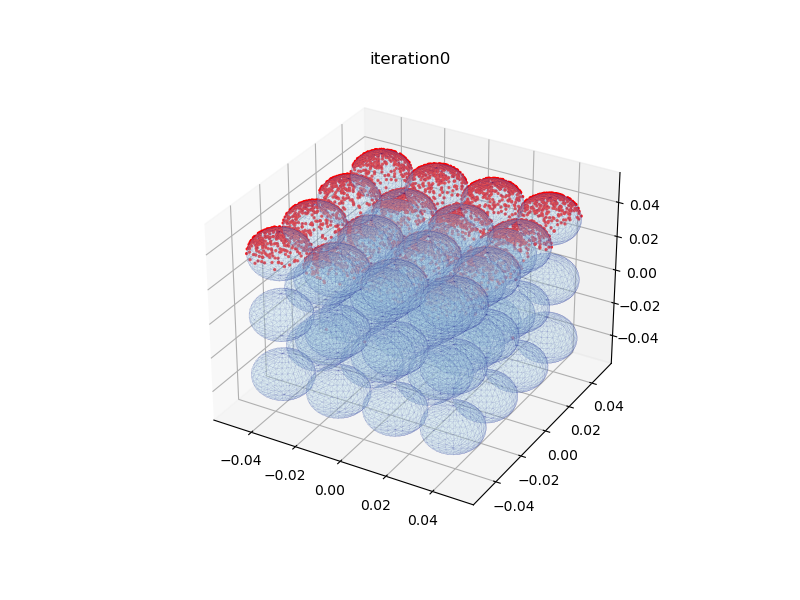

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration0'}>)

In [10]:
# read data from different iterations
_, electrons_inside_iteration0 = read_rootfile("00_stackediteration0_num20000.root")

# Load ASCII STL file
stacked_spheres = mesh.Mesh.from_file('../sphere-charging/geometry/stacked_spheres.stl')  # Replace with your STL path
stacked_spheres.vectors *= 1e-3  # Scale down by 1e-3

# plot the end location of all the stopped electrons inside the spheres
plot_electron_positions(electrons_inside_iteration0, world_dimensions = (-0.05, 0.05), n_bins=50,stacked_spheres=stacked_spheres)

# still need to fix the potential calculation on the stacked spheres
#plot_potential_on_sphere(electrons_inside_iteration0, vmin=-0.05, vmax=0, iteration="iteration0")

# Iteration 1

/tmp/ipykernel_3052041/3513159670.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


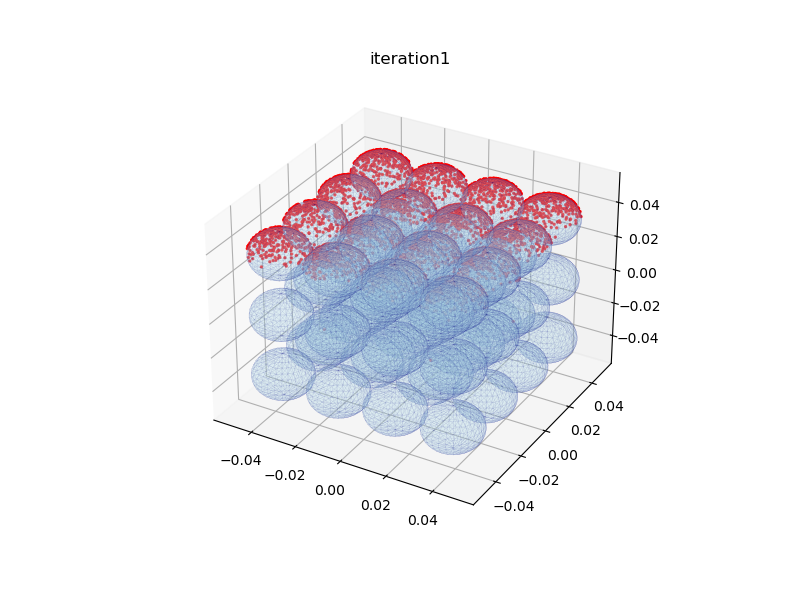

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration1'}>)

In [11]:
# read data from different iterations
_, electrons_inside_iteration1 = read_rootfile("01_stackediteration1_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration1, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration1",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration1, vmin=-0.05, vmax=0, iteration="iteration1")


# Iteration 2

/tmp/ipykernel_3052041/4242052674.py:61: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


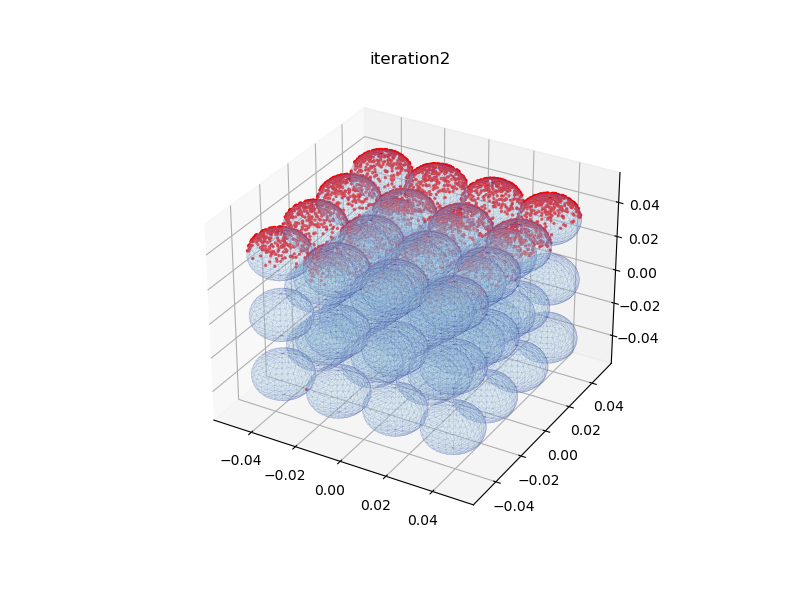

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration2'}>)

In [21]:
# read data from different iterations
_, electrons_inside_iteration2 = read_rootfile("02_stackediteration2_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration2, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration2",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

-0.08594587445899839 -0.005945619568130005


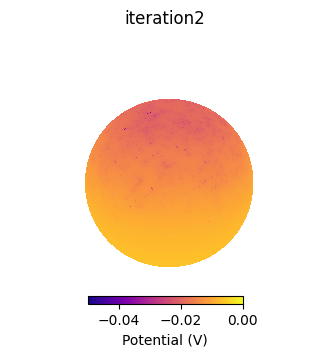

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration2'}>)

In [35]:
# read data from different iterations
_, electrons_inside_iteration2 = read_rootfile("02_iteration2_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration2, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration2")


# Iteration 3

/tmp/ipykernel_3052041/3513159670.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  sc = ax.scatter(x,y,z, s=2, norm=LogNorm(vmin=1, vmax=5), alpha=0.8,color="red")


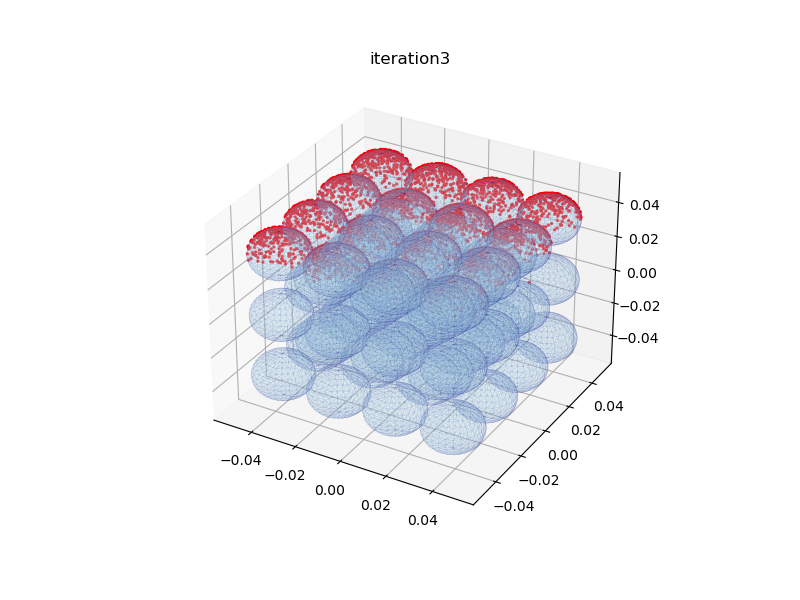

(<Figure size 800x600 with 1 Axes>, <Axes3D: title={'center': 'iteration3'}>)

In [8]:
# read data from different iterations
_, electrons_inside_iteration3 = read_rootfile("03_stackediteration3_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration3, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration3",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

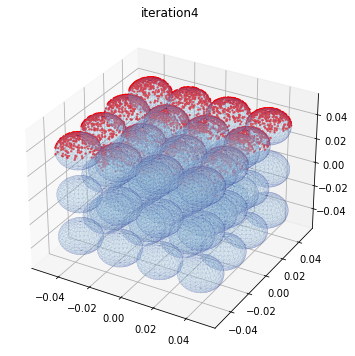

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration4'}>)

In [12]:
# read data from different iterations
_, electrons_inside_iteration4 = read_rootfile("04_stackediteration4_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration4, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration4",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

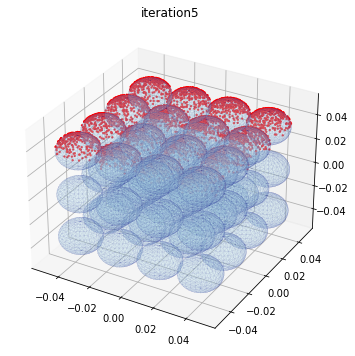

(<Figure size 576x432 with 1 Axes>,
 <Axes3DSubplot:title={'center':'iteration5'}>)

In [11]:
# read data from different iterations
_, electrons_inside_iteration5 = read_rootfile("05_stackediteration5_from_00_num20000.root")

plot_electron_positions(electrons_inside_iteration5, world_dimensions = (-0.05, 0.05), n_bins=10,iteration="iteration5",stacked_spheres=stacked_spheres)
#plot_potential_on_sphere(electrons_inside_iteration2, vmin=-0.05, vmax=0, iteration="iteration1")

-0.06079495675658088 -0.005620294496455831


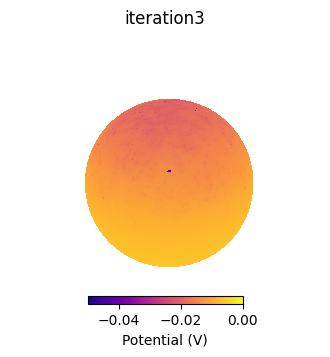

(<Figure size 400x600 with 2 Axes>, <Axes3D: title={'center': 'iteration3'}>)

In [36]:
# read data from different iterations
_, electrons_inside_iteration3 = read_rootfile("03_iteration3_from_00_num5000.root")

#plot_electron_positions(electrons_inside_iteration3, world_dimensions = (-0.05, 0.05), n_bins=100)
plot_potential_on_sphere(electrons_inside_iteration3, vmin=-0.05, vmax=0, iteration="iteration3")


In [ ]:
# ATTEMPTS TO MAKE THE CODE WORK FOR CARTESTIAN COORDINATES

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.constants import epsilon_0, e as q_e
# from matplotlib.colors import LogNorm

# # ----------------------------
# # 1. Electron positions
# # ----------------------------
# coords_m = np.vstack(np.array(electrons_inside_iteration0["Post_Step_Position_mm"])) * 1e-3  # mm to m

# # ----------------------------
# # 2. Define histogram grid
# # ----------------------------

# # Define voxel edges
# n_bins = 100
# world_dimensions = np.array([-0.05, 0.05])*1e-3  # convert mm to m
# x_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# y_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)
# z_edges = np.linspace(world_dimensions[0], world_dimensions[1], n_bins + 1)

# # Compute voxel centers
# x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
# y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])
# z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
# X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

# voxel_centers = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))  # shape (N_voxels, 3)

# # ----------------------------
# # 3. Compute Electric Potential at Voxel Centers
# # ----------------------------
# K = 1.0 / (4.0 * np.pi * epsilon_0 * 3.9)  # SiO2 relative permittivity
# q = -q_e  # charge of an electron

# V_grid = np.zeros(voxel_centers.shape[0])

# for i, p in enumerate(voxel_centers):
#     r_vec = coords_m - p
#     r = np.linalg.norm(r_vec, axis=1)
#     V_grid[i] = K * q * np.sum(1.0 / r)

# V_grid_reshaped = V_grid.reshape(X.shape)  # same shape as the histogram

# # ----------------------------
# # 5. Plot Energy Loss with Potential Overlay (Optional)
# # ----------------------------
# # Mask nonzero energy loss
# mask = V_grid_reshaped > 0
# Xf = X[mask]
# Yf = Y[mask]
# Zf = Z[mask]
# V_values = V_grid_reshaped[mask]

# # Plot energy loss as 3D scatter with potential as color map
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection="3d")

# sc = ax.scatter(
#     Xf * 1e3, Yf * 1e3, Zf * 1e3,  # convert to mm
#     s=2,
#     c=V_values,
#     cmap='plasma',
#     norm=plt.Normalize(vmin=V_grid_reshaped.min(), vmax=V_grid_reshaped.max()),
#     alpha=0.9
# )

# cbar = plt.colorbar(sc, ax=ax, shrink=0.6, label='Electric Potential (V)')
# plt.tight_layout()
# plt.show()
